In [1]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import random_split
import torch.nn.functional as F

device=  "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

data_path = "C:/cv/hair/data/hair"
print(os.listdir(data_path))


cuda:0
['Curly Hair', 'Straight Hair', 'Wavy Hair']


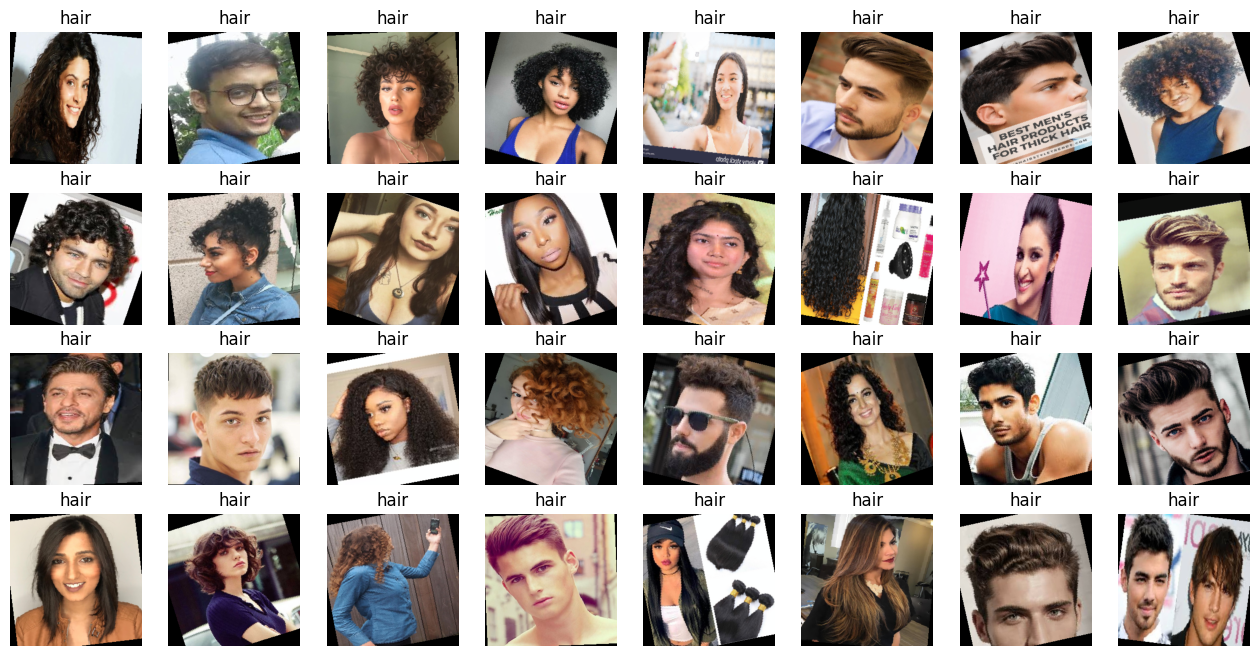

In [2]:
LABELS = ['Curly Hair', 'Straight Hair', 'Wavy Hair']

transformed_data = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def img_inv(image):
    image = image.numpy().transpose((1,2,0))
    image = image * std + mean
    return np.clip(image,0,1)


dataset = datasets.ImageFolder("C:/cv/hair/data",transform=transformed_data)




train_split = int(len(dataset) * 0.8)
test_split = len(dataset) - train_split

train_data,test_data = random_split(dataset, lengths=[train_split,test_split])


BATCH_SIZE = 32
epochs = 5
learning_rate = 0.001


train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)




images,labels = next(iter(train_dataloader))



fig,axs = plt.subplots(4,8,figsize=(16,8))

for i,ax in enumerate(axs.flat):
    image = img_inv(images[i])
    ax.imshow(image)
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.show()



In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.con1 = nn.Conv2d(3, 32,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2,2)
        
        self.con2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.con3 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2,2)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*128, out_features=2),
            nn.ReLU(),
            nn.Dropout(0.1),
            )
        
        
    def forward(self,x):
        x = self.pool1(F.relu(self.bn1(self.con1(x))))
        x = self.pool2(F.relu(self.bn2(self.con2(x))))
        x = self.pool3(F.relu(self.bn3(self.con3(x))))
        x = self.classifier(x)
        return x


model = Net()
model.to(device)

Net(
  (con1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=131072, out_features=2, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
)

In [4]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(epochs):
    running_loss = 0.0
    for i,(images,labels) in enumerate(train_dataloader):
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_dataloader):.4f}")

Epoch [1/5], Loss: 0.1001
Epoch [2/5], Loss: 0.0615
Epoch [3/5], Loss: 0.0775
Epoch [4/5], Loss: 0.0641
Epoch [5/5], Loss: 0.0626


In [5]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images,labels in test_dataloader:
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _,preds = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += torch.sum(preds == labels).sum().item()
        print('Test Accuracy : {} %'.format(100 * correct / total))


Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
Test Accuracy : 100.0 %
